<a href="https://colab.research.google.com/github/Sitaoooo/B20lab_sitao/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this exercise, you implement a very important and popular generative model: variational autoencoder. One main goal of an autoencoder is to learn somewhat useful representation of data (by learning an encoder of the data). Particularly, variational autoencoder (VAE) is additionally used for generative modeling, meaning they can generate new data points that resemble the original input data. After training, you can sample from the latent space to generate new data instances. This is particularly useful in fields like image generation, where VAEs can create new images that share characteristics with a training set.

When it comes to generative models, one can immediately think of learning a distribution $p(x)$ so that we can draw samples from such a distribution. However, it could be challenging in general, as the distribution may not even have a nice format like those well-known Gaussian, uniform, etc., and it is also challenging to draw samples from a distribution of a high-dimensional random variable.

A common way to learn a complicated distribution function is to first introduce some latent variable $z$ that is assumed to be from some simple distribution such as a Gaussian $N(z; 0, I)$, then we can assume our data $x$ is sampled from $x\sim N(x; f(z), g(z)^2)$. We need to:

$\max_\theta E_x[\log p_\theta (x)]$, note that

$\log p_\theta (x) = \log \int_z p_\theta(x|z)p(z) dz$

$
= \log \int_z p_\theta(x|z)p(z) \frac{q_\phi(z|x)}{q_\phi(z|x)} dz \\
= \log E_{q_\phi}[p_\theta(x|z)p(z)/q_\phi(z|x)] \\
\ge E_{q_\phi}[\log p_\theta(x|z)p(z)/q_\phi(z|x)], \text{by Jensen inequality}\\
= E_{q_\phi}[\log p_\theta(x|z)] + E_{q_\phi}[\log p(z)/q_\phi(z|x)] \\
= E_{q_\phi}[\log p_\theta(x|z)] - KL(q_\phi(z|x) || p(z))
$

which is known as the Evidence Lower BOund (ELBO).

To conveniently compute gradient, the first term can be rewritten as (called reparameterization):

$E_{\epsilon\sim N(0, I)}[\log p_\theta(x|z=\sigma_\phi(x) \epsilon + \mu_\phi(x))]$

Based on the above hints, please complete the following.

Q1. Please fill the reparameterize function.

Q2. Please fill the decode function.

Q3. Please fill the forward function.

Q4. Please fill the loss function. You probably want to take a look [wiki page about KL](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions)

Q5. Please fill the final block of code and then run the code so you can draw samples from the VAE after training.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(784, 128)
        self.fc21 = nn.Linear(128, 20)  # Mean
        self.fc22 = nn.Linear(128, 20)  # Log variance

        # Decoder
        self.fc3 = nn.Linear(20, 128)
        self.fc4 = nn.Linear(128, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        # TODO: return what?
        return eps*std+mu

    # TODO: Please fill the decode function
    def decode(self, z):
        return self.fc4(nn.functional.relu(self.fc3(z)))

    # TODO: complete this forward function
    def forward(self, x):
        x = x.view(-1,784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu,logvar)
        return self.decode(z), mu, logvar

# TODO: complete this loss function
def loss_function(recon_x, x, mu, logvar):
    x = x.view(-1,784)
    mse = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ logvar - mu.pow(2) - logvar.exp())
    return mse+KLD

Epoch 0, Loss: 38.8283741607666
Epoch 1, Loss: 28.889289932250975
Epoch 2, Loss: 27.79668588663737
Epoch 3, Loss: 27.284278873697918
Epoch 4, Loss: 26.939102467854816
Epoch 5, Loss: 26.70496539916992
Epoch 6, Loss: 26.502711591593425
Epoch 7, Loss: 26.385285965983073
Epoch 8, Loss: 26.26993792622884


Epoch 9, Loss: 26.177361902872722


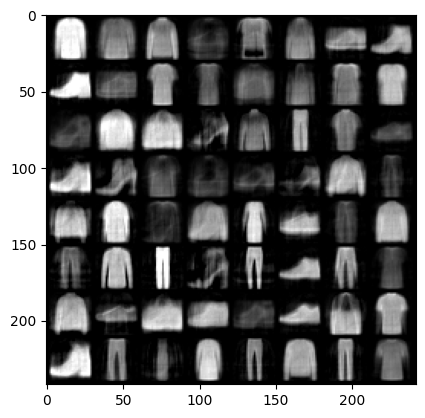

In [ ]:
vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)


num_epochs = 10
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')


with torch.no_grad():
    # TODO: add code to the following two lines
    # so you can draw samples from the autoencoder
    z = torch.randn(64,20)
    sample = vae.decode(z)
    sample = sample.view(64, 1, 28, 28)
    grid_img = torchvision.utils.make_grid(sample, nrow=8)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()
